In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
from nltk.corpus import stopwords
import cv2

**Reading Text Captions**

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("../input/flicker8k-image-captioning/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [4]:
first,second  = captions[10].split('\t')
print(first)
print(second)

1002674143_1b742ab4b8.jpg#0
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


**Dictionary to Map each image with the list of captions it has**

In [5]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    image_name = first.split(".")[0]
    # if the image id is already present or not
    if descriptions.get(image_name) is None:
        descriptions[image_name] = []
    descriptions[image_name].append(second)

In [6]:
descriptions["1002674143_1b742ab4b8"]

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

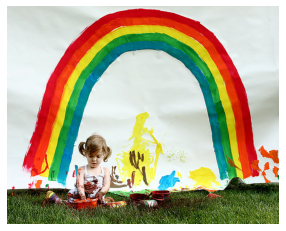

In [7]:
img_path = "../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/"
img = cv2.imread(img_path + "1002674143_1b742ab4b8.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

**Data Cleaning**

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]", " ", sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . #12")

'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it'

In [10]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [11]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Vocabulary**

In [12]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


**Total No of words across all the sentences**

In [13]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words" , len(total_words))

Total Words 373837


**Filter Words from the Vocab according to certain threshold frequncy**

In [14]:

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [15]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]


print(len(total_words))

1845


**Prepare Train and Test Data**

In [16]:
train_file_data = readTextFile("../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.testImages.txt")

In [17]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [18]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [19]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [20]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**Transfer learning**

In [21]:
from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [22]:
model = Xception(weights='imagenet', input_shape=(299,299,3))
model.summary()

91889664/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [23]:
model_new = Model(model.input,model.layers[-2].output)

In [24]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1))
    return feature_vector

In [25]:
encode_img(img_path + "1000268201_693b08cb0e.jpg")

array([0.35922828, 0.03271924, 0.03686444, ..., 0.13820349, 0.02857173,
       0.30709413], dtype=float32)

In [26]:
encoding_train = {}
for img_id in train:
    PATH = img_path + img_id + ".jpg"
    encoding_train[img_id] = encode_img(PATH)

In [27]:
encoding_test = {}
for img_id in test:
    PATH = img_path + img_id + ".jpg"
    encoding_test[img_id] = encode_img(PATH)

In [28]:
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

**Data PreProcessing For Captions**

In [29]:
# Vocab
len(total_words)

1845

In [30]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [31]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847
vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [32]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


**Data Loader (Generator)**

In [53]:
from tensorflow.keras.utils import to_categorical
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

**Word Embeddings**

In [54]:
f = open("../input/glove6b50dtxt/glove.6B.50d.txt",encoding='utf8')

In [55]:
embedding_index = {}
for line in f :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding

In [56]:
embedding_index['machine']

array([-0.34165  , -0.81267  ,  1.4513   ,  0.05914  , -0.080801 ,
        0.39567  ,  0.10064  , -0.5468   , -0.18887  ,  0.11364  ,
       -0.040956 , -0.5637   , -0.32191  ,  0.15968  , -0.59756  ,
       -0.14571  , -0.77074  ,  1.2955   , -0.72002  , -0.90818  ,
        0.76644  ,  0.05346  , -0.0031632, -0.15341  ,  0.22065  ,
       -1.191    , -1.0775   , -0.29768  ,  1.327    , -0.51359  ,
        2.6229   , -0.67411  , -0.82558  ,  0.14283  , -0.014214 ,
        0.90775  ,  0.66828  ,  0.48431  ,  0.1543   ,  0.26044  ,
        1.0191   ,  0.015872 , -0.75325  ,  0.58992  ,  0.4546   ,
       -0.19678  ,  0.42138  , -0.43168  ,  0.11985  ,  0.14094  ])

In [57]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [58]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

**Model Architecture**

In [59]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

#Captions as Input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [60]:
from tensorflow.keras.layers import Add
decoder1 = Add()([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [61]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
_______________________________________________________________________________________

In [62]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [66]:

model.compile(loss='categorical_crossentropy',optimizer='adam')

**Training Model**

In [67]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)// batch_size
#number_pics_per_batch

In [68]:
generator = data_generator(train_descriptions,encoding_train,word_to_idx,
                                   max_len,batch_size)
model.fit_generator(generator,epochs=20,steps_per_epoch=steps)

Epoch 1/20
2000/2000 [==============================] - 33s 17ms/step - loss: 4.0653
Epoch 2/20
2000/2000 [==============================] - 32s 16ms/step - loss: 3.5200
Epoch 3/20
2000/2000 [==============================] - 34s 17ms/step - loss: 3.2664
Epoch 4/20
2000/2000 [==============================] - 32s 16ms/step - loss: 3.1047
Epoch 5/20
2000/2000 [==============================] - 33s 17ms/step - loss: 2.9887
Epoch 6/20
2000/2000 [==============================] - 32s 16ms/step - loss: 2.9011
Epoch 7/20
2000/2000 [==============================] - 33s 17ms/step - loss: 2.8275
Epoch 8/20
2000/2000 [==============================] - 33s 17ms/step - loss: 2.7681
Epoch 9/20
2000/2000 [==============================] - 33s 16ms/step - loss: 2.7161
Epoch 10/20
2000/2000 [==============================] - 34s 17ms/step - loss: 2.6745
Epoch 11/20
2000/2000 [==============================] - 32s 16ms/step - loss: 2.6365
Epoch 12/20
2000/2000 [==============================] - 34s 17

In [69]:
model.save('model.h5')

**Predictions**

In [70]:
def predict_caption(img):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([img,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' +  word)
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

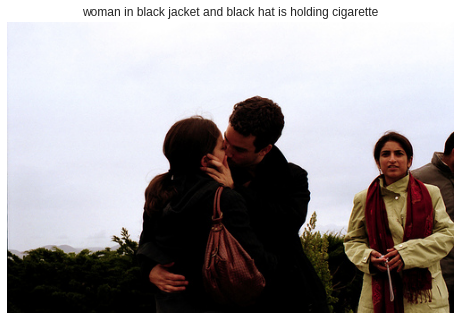

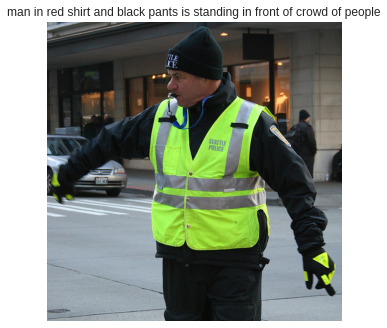

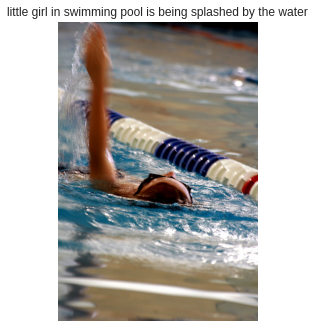

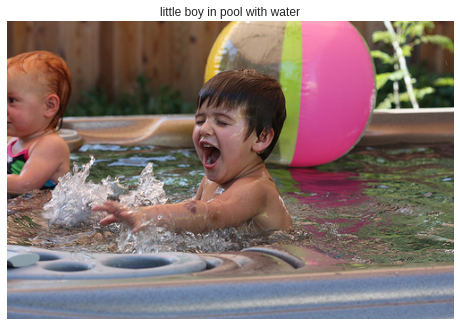

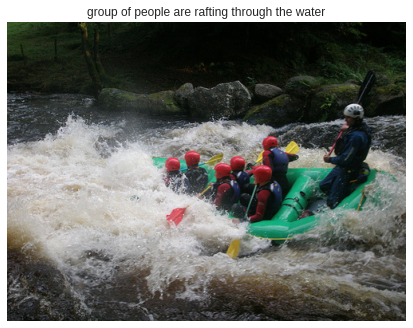

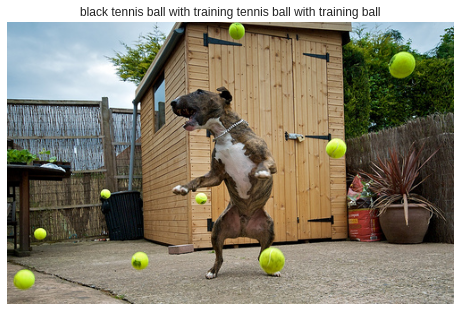

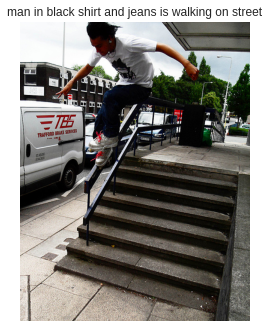

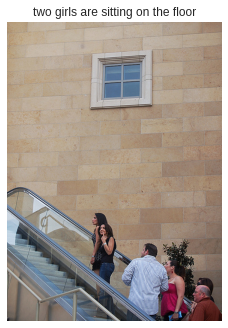

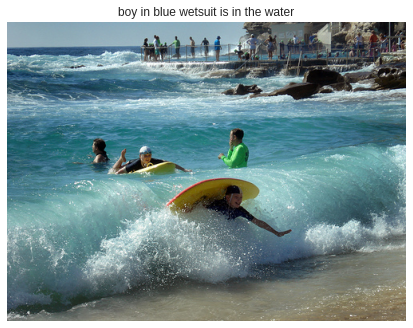

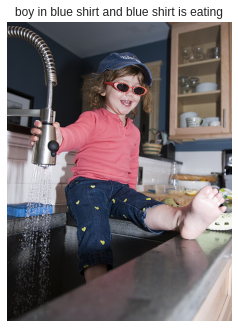

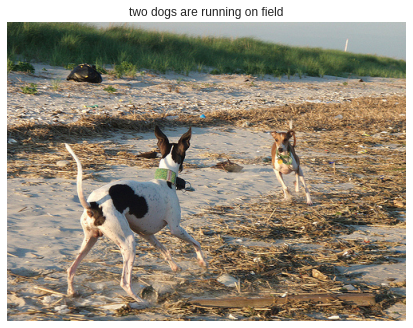

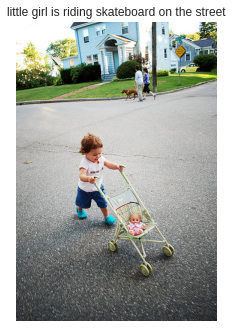

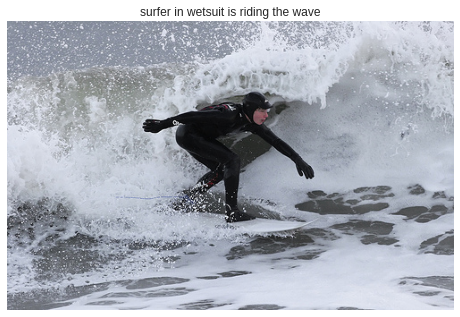

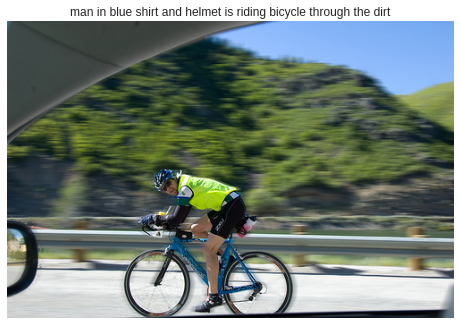

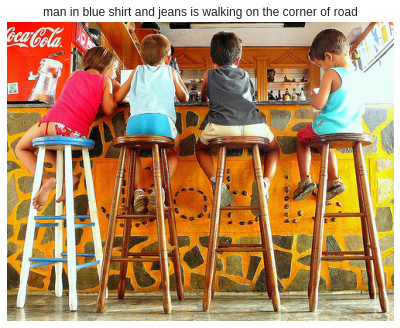

In [73]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()